`antman` kernel

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import Bio.SeqIO as SeqIO
import sys
from tqdm import tqdm
import os 
import re
from pygenomeviz import GenomeViz
import scipy.stats as stats
import seaborn as sns
sys.path.append('../')
from transcriptomics import *
from hcr import * 
from plotting import * 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
white_plotting()

Initializing transcriptomics package
Initializing HCR package
Initializing plotting package


In [81]:
# use arial text for all plots 
plt.rcParams['font.family'] = 'Arial'

In [2]:
tr = load_transcriptome_object("../raw-data/OBir/transcriptome/biroi_transcriptome.pkl")

In [3]:
# Load or_db
or_db = pd.read_excel('../raw-data/OBir/ORs/OR List.xlsx') 
or_db.loc[or_db.gene_name.isin(['Or5-9E198', 'Or5-9E200', 'Or5-9E201']), 'tandem_array'] = 35

In [4]:
# iterate through each row of or_db 
for i, row in or_db.iterrows(): 
    gene = tr.get_gene(row.gene_name) 
    transcript = gene.get_transcript_longest_cds()
    bounds = transcript.get_bounds()
    or_db.at[i, 'n_transcripts'] = len(gene.transcripts)
    or_db.at[i,'start'] = bounds[0]
    or_db.at[i,'end'] = bounds[1] 
    if len(transcript.cds) > 0:
        or_db.at[i,'cds_start'] = int(transcript.cds[0].position[0]) if transcript.strand == '+' and len(transcript.cds) > 0 else int(transcript.cds[0].position[1])
    or_db.at[i,'strand'] = transcript.strand 
    or_db.at[i, 'chr'] = transcript.chromosome
    or_db.at[i,'nine_exon'] = "9E" in row['gene_name']
    or_db.at[i,'ta_size'] = or_db.loc[or_db.tandem_array == row['tandem_array']].shape[0]
    or_db.at[i,'ta_index'] = or_db.loc[or_db.tandem_array == row['tandem_array']].index.get_loc(i) + 1
or_db['start'] = or_db['start'].astype(int)
or_db['end'] = or_db['end'].astype(int)
or_db['ta_size'] = or_db['ta_size'].astype(int)
or_db['ta_index'] = or_db['ta_index'].astype(int)
or_db.head(5)

,chromosome,gene_name,tandem_array,rank,orientation,n_transcripts,start,end,cds_start,strand,chr,nine_exon,ta_size,ta_index
0,1,Or5-R2,70,1,3',1.0,6504395,6510987,6510023.0,-,Chr1,False,2,1
1,1,Or5-Q1,70,2,5',1.0,6511625,6514800,6514732.0,-,Chr1,False,2,2
2,1,Or5-Orco,72,3,NaN,1.0,10910490,10919026,10911295.0,+,Chr1,False,2,1
3,1,Or5-Q2,72,4,NaN,2.0,10934666,10938750,10934709.0,+,Chr1,False,2,2
4,1,Or5-9E1,73,5,NaN,7.0,10980671,10984094,10981538.0,+,Chr1,True,1,1


In [5]:
# Load genome
genome_path = "../raw-data/OBir/genome/Obir.assembly.v5.4.fasta"
genome_seq = SeqIO.to_dict(SeqIO.parse(genome_path, "fasta"))

### Load csRNA-seq Data

In [6]:
# Load csRNAseq data
csRNAseq_dir = "../raw-data/OBir/csRNAseq/"
csRNAseq_files = [f for f in os.listdir(csRNAseq_dir) if f.endswith('.bedGraph')]
print(f"Found {len(csRNAseq_files)} csRNAseq files.")
print(csRNAseq_files)

Found 4 csRNAseq files.
['Ooceraea_biroi-WholeAdults_csRNA-r1.negStrand.renamed.bedGraph', 'Ooceraea_biroi-WholeAdults_sRNA-r1.posStrand.renamed.bedGraph', 'Ooceraea_biroi-WholeAdults_sRNA-r1.negStrand.renamed.bedGraph', 'Ooceraea_biroi-WholeAdults_csRNA-r1.posStrand.renamed.bedGraph']


In [7]:
# Specify adult csRNAseq data, pos and neg strands 
csWAneg_path = os.path.join(csRNAseq_dir, 'Ooceraea_biroi-WholeAdults_csRNA-r1.negStrand.renamed.bedGraph')
csWApos_path = os.path.join(csRNAseq_dir, 'Ooceraea_biroi-WholeAdults_csRNA-r1.posStrand.renamed.bedGraph')

In [8]:
csWAneg = pd.read_csv(csWAneg_path, sep="\t", header=None, names=["chrom", "start", "end", "value"])
csWAneg['strand'] = '-' 
csWApos = pd.read_csv(csWApos_path, sep="\t", header=None, names=["chrom", "start", "end", "value"])
csWApos['strand'] = '+'
csWA = pd.concat([csWAneg, csWApos], ignore_index=True)
csWA

,chrom,start,end,value,strand
0,"track type=bedGraph name=""Ooceraea_biroi-Whole...",NaN,NaN,NaN,-
1,Chr1,110792.0,110823.0,-1.24,-
2,Chr1,122682.0,122683.0,-1.24,-
3,Chr1,122683.0,122684.0,-4.96,-
4,Chr1,122684.0,122714.0,-6.21,-
...,...,...,...,...,...
920935,QOIP01000080.1,13168.0,13172.0,3.72,+
920936,QOIP01000080.1,13172.0,13173.0,4.96,+
920937,QOIP01000080.1,13173.0,13174.0,8.69,+
920938,QOIP01000093.1,6524.0,6549.0,1.24,+


In [9]:
# Drop rows with NaN in value column, reset index, also drop rows without "Chr" in the chrom 
csWA = csWA.dropna(subset=['value'])
csWA = csWA[csWA['chrom'].str.contains("Chr")]
csWA = csWA.reset_index(drop=True)  
csWA['start'] = csWA['start'].astype(int)
csWA['end'] = csWA['end'].astype(int)
csWA['value'] = np.abs(csWA['value'])  # Ensure values are positive
csWA['length'] = csWA['end'] - csWA['start']
csWA['location'] = csWA['chrom'] + ':' + csWA['start'].astype(str) + '-' + csWA['end'].astype(str)
csWA

,chrom,start,end,value,strand,length,location
0,Chr1,110792,110823,1.24,-,31,Chr1:110792-110823
1,Chr1,122682,122683,1.24,-,1,Chr1:122682-122683
2,Chr1,122683,122684,4.96,-,1,Chr1:122683-122684
3,Chr1,122684,122714,6.21,-,30,Chr1:122684-122714
4,Chr1,138377,138407,2.48,-,30,Chr1:138377-138407
...,...,...,...,...,...,...,...
920146,Chr14,8701726,8701732,6.21,+,6,Chr14:8701726-8701732
920147,Chr14,8701732,8701733,4.97,+,1,Chr14:8701732-8701733
920148,Chr14,8701733,8701756,3.73,+,23,Chr14:8701733-8701756
920149,Chr14,8702324,8702344,1.25,+,20,Chr14:8702324-8702344


### Specify windows upstream of ORs to search for csRNA-seq reads

Take a 1kbp window upstream of the CDS start site

In [10]:
# Specify regions of interest (1kbp upstream of each OR's CDS start)
dist_upstream = 1000 

OR_rois = [] 

for i, row in or_db.iterrows():
    if pd.isna(row['chr']) or pd.isna(row['cds_start']):
        continue
    chrom = row['chr']
    chrom_num = int(chrom.replace('Chr', ''))  # Convert 'Chr1' to 1, 'Chr2' to 2, etc.
    strand = row['strand']
    start = row['cds_start'] - dist_upstream if strand == '+' else row['cds_start']
    end = row['cds_start'] if strand == '+' else row['cds_start'] + dist_upstream
    roi = {'chrom': chrom, 'chrom_num': chrom_num, 'start': start, 'end': end, 'strand': strand, 'gene_name': row['gene_name']}
    OR_rois.append(roi)

OR_rois = pd.DataFrame(OR_rois)
# Convert start and end to ints
OR_rois['start'] = OR_rois['start'].astype(int)
OR_rois['end'] = OR_rois['end'].astype(int)
OR_rois

,chrom,chrom_num,start,end,strand,gene_name
0,Chr1,1,6510023,6511023,-,Or5-R2
1,Chr1,1,6514732,6515732,-,Or5-Q1
2,Chr1,1,10910295,10911295,+,Or5-Orco
3,Chr1,1,10933709,10934709,+,Or5-Q2
4,Chr1,1,10980538,10981538,+,Or5-9E1
...,...,...,...,...,...,...
493,Chr12,12,8807087,8808087,+,Or5-L35
494,Chr12,12,12304782,12305782,+,Or5-9E350
495,Chr12,12,13237580,13238580,-,Or5-9E351
496,Chr12,12,13619576,13620576,-,Or5-9Efrag3


In [11]:
# Convert OR_rois to a numpy array 
OR_rois_array = OR_rois[['chrom', 'start', 'end']].to_numpy()

# Use the first column to filter 
OR_rois_array_dict = {}
for chrom, start, end in OR_rois_array:
    if chrom not in OR_rois_array_dict:
        OR_rois_array_dict[chrom] = []
    OR_rois_array_dict[chrom].append((start, end))

In [12]:
OR_rois_array_dict.keys()

dict_keys(['Chr1', 'Chr2', 'Chr3', 'Chr4', 'Chr5', 'Chr6', 'Chr7', 'Chr8', 'Chr9', 'Chr10', 'Chr11', 'Chr12', 'Chr14'])

### Take intersection to remove non-OR-related csRNA-seq Data

In [13]:
# Drop rows where chrom is not in OR_rois_array_dict keys 
csWA = csWA[csWA['chrom'].isin(OR_rois_array_dict.keys())].reset_index(drop=True)

In [14]:
# Take intersection of csRNAseq data with OR regions of interest
from tqdm import tqdm

# Initialize a list to store overlapping regions
overlapping = np.zeros(csWA.shape[0], dtype=bool)

for i, row in tqdm(csWA.iterrows(), total=csWA.shape[0], desc="Processing csRNAseq data"):
    OR_rois_chrom = OR_rois_array_dict[row['chrom']]
    for start, end in OR_rois_chrom:
        if start <= row['start'] and row['end'] <= end:
            # Overlapping region found
            overlapping[i] = True
            break


Processing csRNAseq data: 100%|██████████| 893560/893560 [00:43<00:00, 20565.07it/s]


In [15]:
# Look for overlapping regions
csWA['overlapping'] = overlapping
print(f"Number of overlapping regions: {np.sum(overlapping)} out of {csWA.shape[0]} total regions.")

# Filter csWA to keep only overlapping regions
csWA = csWA[csWA['overlapping']].reset_index(drop=True)

# Drop the 'overlapping' column
csWA = csWA.drop(columns=['overlapping'])

Number of overlapping regions: 869 out of 893560 total regions.


In [16]:
save_1 = csWA.copy() 

In [17]:
csWA = save_1.copy()

In [18]:
# Save gene name and strand information from OR_rois to csWA
for i, row in tqdm(csWA.iterrows(), total=csWA.shape[0], desc="Processing csRNAseq data"):
    # Find row in OR_rois 
    for j, or_row in OR_rois.iterrows():
        if row['chrom'] == or_row['chrom'] and row['start'] >= or_row['start'] and row['end'] <= or_row['end']:
            # Found a matching OR region
            csWA.at[i, 'gene_name'] = or_row['gene_name']
            csWA.at[i, 'gene_strand'] = or_row['strand']
            break

Processing csRNAseq data: 100%|██████████| 869/869 [00:02<00:00, 330.90it/s]


In [19]:
# Look for Nan Rows 
csWA[csWA.isna().any(axis=1)]

,chrom,start,end,value,strand,length,location,gene_name,gene_strand


## Plot examples

In [58]:
genes_with_both_peaks = csWA['gene_name'].unique()
genes_with_both_peaks = [gene for gene in genes_with_both_peaks if csWA[csWA['gene_name'] == gene]['strand'].nunique() > 1]
csWA_with_both_peaks = csWA[csWA['gene_name'].isin(genes_with_both_peaks)].reset_index(drop=True)
# Drop duplicates in gene_name and strand
csWA_with_both_peaks = csWA_with_both_peaks.drop_duplicates(subset=['gene_name', 'strand'])
# pandas display 20 rows
pd.set_option('display.max_rows', 20)
csWA_with_both_peaks.sort_values(by=['value'], ascending=False).head(20)

,chrom,start,end,value,strand,length,location,gene_name,gene_strand
161,Chr4,10576216,10576219,79.49,+,3,Chr4:10576216-10576219,Or5-9E114,-
178,Chr4,10582128,10582152,34.81,+,24,Chr4:10582128-10582152,Or5-9E115,-
285,Chr10,13012293,13012329,27.31,+,36,Chr10:13012293-13012329,Or5-9E319,-
221,Chr10,1378544,1378554,18.62,+,10,Chr10:1378544-1378554,Or5-9E239,+
254,Chr10,2001055,2001077,16.14,+,22,Chr10:2001055-2001077,Or5-9E247,-
142,Chr2,2463442,2463465,14.89,+,23,Chr2:2463442-2463465,Or5-9E20,-
184,Chr4,10589077,10589109,13.71,+,32,Chr4:10589077-10589109,Or5-9E116,-
272,Chr10,12897674,12897699,12.41,+,25,Chr10:12897674-12897699,Or5-9E293,-
26,Chr3,4567319,4567321,7.45,-,2,Chr3:4567319-4567321,Or5-U1,+
150,Chr2,16692857,16692878,7.44,+,21,Chr2:16692857-16692878,Or5-9E54,-


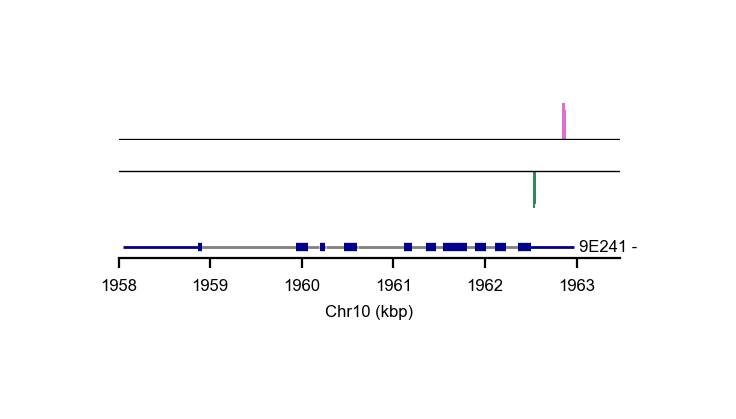

In [22]:
gene_name = "Or5-9E241"

# base pairs upstream of the gene to include in the plot
bp_upstream = 500  

# Get bounds 
transcript = tr.get_gene(gene_name).get_transcript_longest_cds()
chromosome = transcript.chromosome
gene_start = int(transcript.get_bounds()[0]) 
gene_end = int(transcript.get_bounds()[1]) 
start = gene_start - bp_upstream if transcript.strand == '+' else gene_start - 50 
end = gene_end + bp_upstream if transcript.strand == '-' else gene_end + 50 

f, axs = plt.subplots(3, 1, figsize=(3, 1.4), dpi=200, height_ratios=[1, 1, 0.4])
f.subplots_adjust(hspace=0)

csWA_gene = csWA[csWA['gene_name'] == gene_name]


# Plot csRNAseq data, using fill_between for better visibility
for i, row in csWA_gene.iterrows():
    if row['strand'] == '+':
        axs[0].fill_between([row['start'], row['end']], [row['value'], row['value']], color='orchid', alpha=1, lw=0, edgecolor=None)
    else:
        axs[1].fill_between([row['start'], row['end']], [-row['value'], -row['value']], color='seagreen', alpha=1, lw=0, edgecolor=None)

axs[0].set_ylim(-0.1, csWA_gene[csWA_gene['strand'] == '+']['value'].max() * 1.1)
axs[1].set_ylim(-csWA_gene[csWA_gene['strand'] == '-']['value'].max() * 1.1, 0.1)

axs[0].plot([start, end], [0, 0], color='k', lw=1.2)
axs[1].plot([start, end], [0, 0], color='k', lw=0.5)

for ax in axs[:-1]: 
        ax.spines['bottom'].set_visible(False)
        ax.xaxis.set_visible(False)

ax = axs[2]
for exon in transcript.exons: 
        ax.plot([exon.position[0], exon.position[1]], [1, 1], color='darkblue', lw=1, solid_capstyle='butt')
for intron in transcript.introns: 
        ax.plot([intron.position[0], intron.position[1]], [1, 1], color='grey', lw=1, solid_capstyle='butt')
for cds in transcript.cds: 
        ax.plot([cds.position[0], cds.position[1]], [1, 1], color='darkblue', lw=3, solid_capstyle='butt')

label = f"{gene_name.replace('Or5-', '')} {transcript.strand}"
ax.text(gene_end + 50, 1, label, fontsize=6, ha='left', va='center', color='k')
ax.set_ylim(0.5, 1.2)

# Divide all xticklabels by 1000 
xticks = np.arange(start, end + 1, 1_000)
xticklabels = [f"{int(x / 1000)}" for x in xticks]
ax.set_xticks(xticks, labels=xticklabels, fontsize=6) 
ax.set_xlabel(f'{chromosome} (kbp)', fontsize=6)


for ax in axs: 
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.set_yticks([])
        ax.set_xlim(start, end)


plt.tight_layout()
plt.savefig(f'../figures/csRNAseq-{gene_name}.pdf', pad_inches=0, bbox_inches=0, transparent=False)
plt.show()


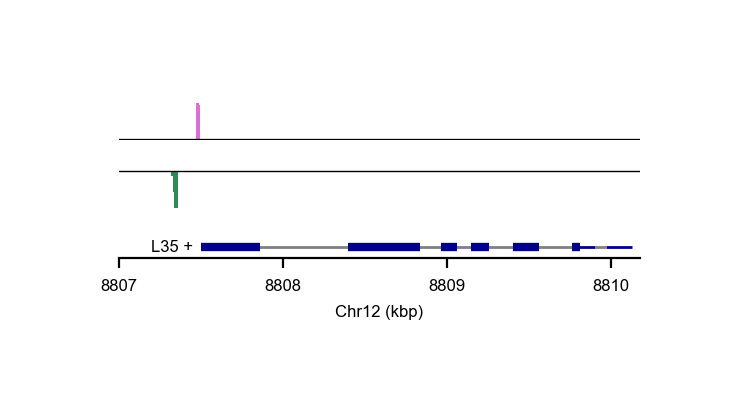

In [23]:
gene_name = "Or5-L35"

# base pairs upstream of the gene to include in the plot
bp_upstream = 500  

# Get bounds 
transcript = tr.get_gene(gene_name).get_transcript_longest_cds()
chromosome = transcript.chromosome
gene_start = int(transcript.get_bounds()[0]) 
gene_end = int(transcript.get_bounds()[1]) 
start = gene_start - bp_upstream if transcript.strand == '+' else gene_start - 50 
end = gene_end + bp_upstream if transcript.strand == '-' else gene_end + 50 

f, axs = plt.subplots(3, 1, figsize=(3, 1.4), dpi=200, height_ratios=[1, 1, 0.4])
f.subplots_adjust(hspace=0)

csWA_gene = csWA[csWA['gene_name'] == gene_name]


# Plot csRNAseq data, using fill_between for better visibility
for i, row in csWA_gene.iterrows():
    if row['strand'] == '+':
        axs[0].fill_between([row['start'], row['end']], [row['value'], row['value']], color='orchid', alpha=1, lw=0, edgecolor=None)
    else:
        axs[1].fill_between([row['start'], row['end']], [-row['value'], -row['value']], color='seagreen', alpha=1, lw=0, edgecolor=None)

axs[0].set_ylim(-0.1, csWA_gene[csWA_gene['strand'] == '+']['value'].max() * 1.1)
axs[1].set_ylim(-csWA_gene[csWA_gene['strand'] == '-']['value'].max() * 1.1, 0.1)

axs[0].plot([start, end], [0, 0], color='k', lw=1.2)
axs[1].plot([start, end], [0, 0], color='k', lw=0.5)

for ax in axs[:-1]: 
        ax.spines['bottom'].set_visible(False)
        ax.xaxis.set_visible(False)

ax = axs[2]
for exon in transcript.exons: 
        ax.plot([exon.position[0], exon.position[1]], [1, 1], color='darkblue', lw=1, solid_capstyle='butt')
for intron in transcript.introns: 
        ax.plot([intron.position[0], intron.position[1]], [1, 1], color='grey', lw=1, solid_capstyle='butt')
for cds in transcript.cds: 
        ax.plot([cds.position[0], cds.position[1]], [1, 1], color='darkblue', lw=3, solid_capstyle='butt')

label = f"{gene_name.replace('Or5-', '')} {transcript.strand}"
ax.text(gene_start - 300, 1, label, fontsize=6, ha='left', va='center', color='k')
ax.set_ylim(0.5, 1.2)

# Divide all xticklabels by 1000 
xticks = np.arange(start, end + 1, 1_000)
xticklabels = [f"{int(x / 1000)}" for x in xticks]
ax.set_xticks(xticks, labels=xticklabels, fontsize=6) 
ax.set_xlabel(f'{chromosome} (kbp)', fontsize=6)


for ax in axs: 
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.set_yticks([])
        ax.set_xlim(start, end)


plt.tight_layout()
plt.savefig(f'../figures/csRNAseq-{gene_name}.pdf', pad_inches=0, bbox_inches=0, transparent=False)
plt.show()



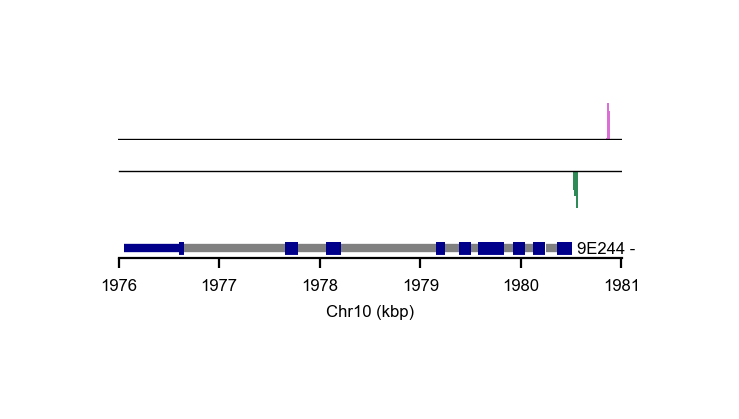

In [80]:
gene_name = "Or5-9E244"

# base pairs upstream of the gene to include in the plot
bp_upstream = 500  

# Get bounds 
transcript = tr.get_gene(gene_name).get_transcript_longest_cds()
chromosome = transcript.chromosome
gene_start = int(transcript.get_bounds()[0]) 
gene_end = int(transcript.get_bounds()[1]) 
start = gene_start - bp_upstream if transcript.strand == '+' else gene_start - 50 
end = gene_end + bp_upstream if transcript.strand == '-' else gene_end + 50 

f, axs = plt.subplots(3, 1, figsize=(3, 1.4), dpi=200, height_ratios=[1, 1, 0.4])
f.subplots_adjust(hspace=0)

csWA_gene = csWA[csWA['gene_name'] == gene_name]


# Plot csRNAseq data, using fill_between for better visibility
for i, row in csWA_gene.iterrows():
    if row['strand'] == '+':
        axs[0].fill_between([row['start'], row['end']], [row['value'], row['value']], color='orchid', alpha=1, lw=0, edgecolor=None)
    else:
        axs[1].fill_between([row['start'], row['end']], [-row['value'], -row['value']], color='seagreen', alpha=1, lw=0, edgecolor=None)

axs[0].set_ylim(-0.1, csWA_gene[csWA_gene['strand'] == '+']['value'].max() * 1.1)
axs[1].set_ylim(-csWA_gene[csWA_gene['strand'] == '-']['value'].max() * 1.1, 0.1)

axs[0].plot([start, end], [0, 0], color='k', lw=1.2)
axs[1].plot([start, end], [0, 0], color='k', lw=0.5)

for ax in axs[:-1]: 
        ax.spines['bottom'].set_visible(False)
        ax.xaxis.set_visible(False)

ax = axs[2]
for exon in transcript.exons: 
        ax.plot([exon.position[0], exon.position[1]], [1, 1], color='darkblue', lw=3, solid_capstyle='butt')
for intron in transcript.introns: 
        ax.plot([intron.position[0], intron.position[1]], [1, 1], color='grey', lw=3, solid_capstyle='butt')
for cds in transcript.cds: 
        ax.plot([cds.position[0], cds.position[1]], [1, 1], color='darkblue', lw=5, solid_capstyle='butt')

label = f"{gene_name.replace('Or5-', '')} {transcript.strand}"
ax.text(gene_end + 50, 1, label, fontsize=6, ha='left', va='center', color='k')
ax.set_ylim(0, 1.6)

# Divide all xticklabels by 1000 
xticks = np.arange(start, end + 1, 1_000)
xticklabels = [f"{int(x / 1000)}" for x in xticks]
ax.set_xticks(xticks, labels=xticklabels, fontsize=6) 
ax.set_xlabel(f'{chromosome} (kbp)', fontsize=6)


for ax in axs: 
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.set_yticks([])
        ax.set_xlim(start, end)


plt.tight_layout()
plt.savefig(f'../figures/csRNAseq-{gene_name}.pdf', pad_inches=0, bbox_inches=0, transparent=False)
plt.show()



### 9E241 and lncRNA

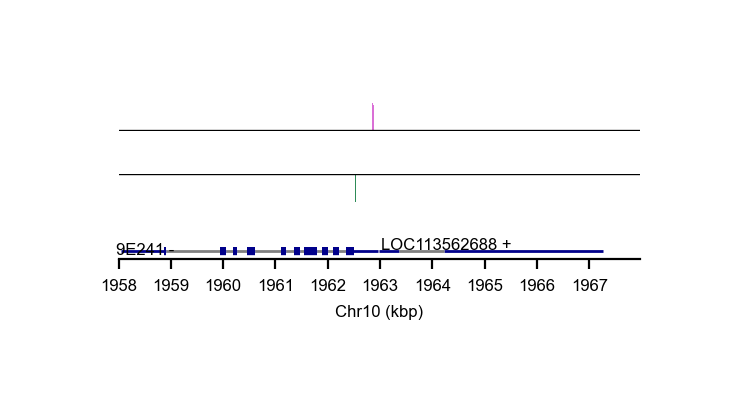

In [35]:
gene_name = "Or5-9E241"

# base pairs upstream of the gene to include in the plot
bp_upstream = 5_000  

# Get bounds 
transcript = tr.get_gene(gene_name).get_transcript_longest_cds()
chromosome = transcript.chromosome
gene_start = int(transcript.get_bounds()[0]) 
gene_end = int(transcript.get_bounds()[1]) 
start = gene_start - bp_upstream if transcript.strand == '+' else gene_start - 50 
end = gene_end + bp_upstream if transcript.strand == '-' else gene_end + 50 

f, axs = plt.subplots(3, 1, figsize=(3, 1.4), dpi=200, height_ratios=[1, 1, 0.4])
f.subplots_adjust(hspace=0)

csWA_gene = csWA[csWA['gene_name'] == gene_name]

# Plot csRNAseq data, using fill_between for better visibility
for i, row in csWA_gene.iterrows():
    if row['strand'] == '+':
        axs[0].fill_between([row['start'], row['end']], [row['value'], row['value']], color='orchid', alpha=1, lw=0, edgecolor=None)
    else:
        axs[1].fill_between([row['start'], row['end']], [-row['value'], -row['value']], color='seagreen', alpha=1, lw=0, edgecolor=None)

axs[0].set_ylim(-0.1, csWA_gene[csWA_gene['strand'] == '+']['value'].max() * 1.1)
axs[1].set_ylim(-csWA_gene[csWA_gene['strand'] == '-']['value'].max() * 1.1, 0.1)

axs[0].plot([start, end], [0, 0], color='k', lw=1.2)
axs[1].plot([start, end], [0, 0], color='k', lw=0.5)

for ax in axs[:-1]: 
        ax.spines['bottom'].set_visible(False)
        ax.xaxis.set_visible(False)

ax = axs[2]
for exon in transcript.exons: 
        ax.plot([exon.position[0], exon.position[1]], [1, 1], color='darkblue', lw=1, solid_capstyle='butt')
for intron in transcript.introns: 
        ax.plot([intron.position[0], intron.position[1]], [1, 1], color='grey', lw=1, solid_capstyle='butt')
for cds in transcript.cds: 
        ax.plot([cds.position[0], cds.position[1]], [1, 1], color='darkblue', lw=3, solid_capstyle='butt')

label = f"{gene_name.replace('Or5-', '')} {transcript.strand}"
ax.text(gene_start - 100, 1, label, fontsize=6, ha='left', va='center', color='k')
ax.set_ylim(0.5, 1.2)


transcript = tr.get_gene('LOC113562688').get_transcript_longest_bounds()
for exon in transcript.exons: 
        ax.plot([exon.position[0], exon.position[1]], [1, 1], color='darkblue', lw=1, solid_capstyle='butt')
for intron in transcript.introns: 
        ax.plot([intron.position[0], intron.position[1]], [1, 1], color='grey', lw=1, solid_capstyle='butt')
for cds in transcript.cds: 
        ax.plot([cds.position[0], cds.position[1]], [1, 1], color='darkblue', lw=3, solid_capstyle='butt')

label = f"LOC113562688 {transcript.strand}"
ax.text(transcript.get_bounds()[0] + 50, 1.3, label, fontsize=6, ha='left', va='center', color='k')
ax.set_ylim(0.5, 1.2)

# Divide all xticklabels by 1000 
xticks = np.arange(start, end + 1, 1_000)
xticklabels = [f"{int(x / 1000)}" for x in xticks]
ax.set_xticks(xticks, labels=xticklabels, fontsize=6) 
ax.set_xlabel(f'{chromosome} (kbp)', fontsize=6)


for ax in axs: 
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.set_yticks([])
        ax.set_xlim(start, end)


plt.tight_layout()
plt.savefig(f'../figures/csRNAseq-{gene_name}-with-lncRNA.pdf', pad_inches=0, bbox_inches=0, transparent=False)
plt.show()


## L35 and lncRNA

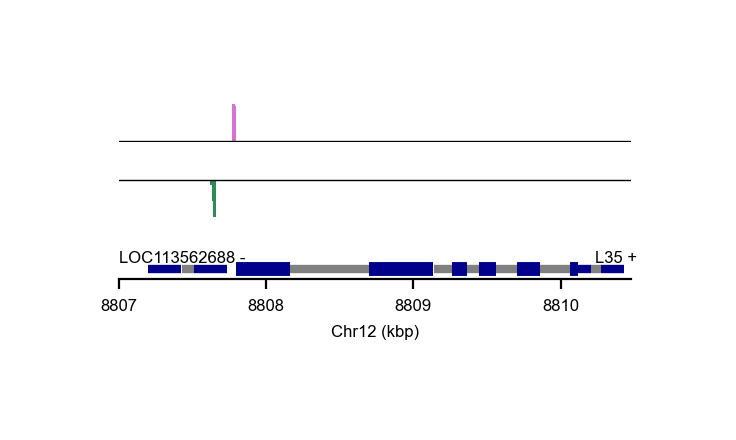

In [71]:
gene_name = "Or5-L35"

# base pairs upstream of the gene to include in the plot
bp_upstream = 800  

# Get bounds 
transcript = tr.get_gene(gene_name).get_transcript_longest_cds()
chromosome = transcript.chromosome
gene_start = int(transcript.get_bounds()[0]) 
gene_end = int(transcript.get_bounds()[1]) 
start = gene_start - bp_upstream if transcript.strand == '+' else gene_start - 50 
end = gene_end + bp_upstream if transcript.strand == '-' else gene_end + 50 

f, axs = plt.subplots(3, 1, figsize=(3, 1.5), dpi=200, height_ratios=[1, 1, 0.5])
f.subplots_adjust(hspace=0)

csWA_gene = csWA[csWA['gene_name'] == gene_name]


# Plot csRNAseq data, using fill_between for better visibility
for i, row in csWA_gene.iterrows():
    if row['strand'] == '+':
        axs[0].fill_between([row['start'], row['end']], [row['value'], row['value']], color='orchid', alpha=1, lw=0, edgecolor=None)
    else:
        axs[1].fill_between([row['start'], row['end']], [-row['value'], -row['value']], color='seagreen', alpha=1, lw=0, edgecolor=None)

axs[0].set_ylim(-0.1, csWA_gene[csWA_gene['strand'] == '+']['value'].max() * 1.1)
axs[1].set_ylim(-csWA_gene[csWA_gene['strand'] == '-']['value'].max() * 1.1, 0.1)

axs[0].plot([start, end], [0, 0], color='k', lw=1.2)
axs[1].plot([start, end], [0, 0], color='k', lw=0.5)

for ax in axs[:-1]: 
        ax.spines['bottom'].set_visible(False)
        ax.xaxis.set_visible(False)

ax = axs[2]
for exon in transcript.exons: 
        ax.plot([exon.position[0], exon.position[1]], [1, 1], color='darkblue', lw=3, solid_capstyle='butt')
for intron in transcript.introns: 
        ax.plot([intron.position[0], intron.position[1]], [1, 1], color='grey', lw=3, solid_capstyle='butt')
for cds in transcript.cds: 
        ax.plot([cds.position[0], cds.position[1]], [1, 1], color='darkblue', lw=5, solid_capstyle='butt')

label = f"{gene_name.replace('Or5-', '')} {transcript.strand}"
ax.text(gene_end -200, 2, label, fontsize=6, ha='left', va='center', color='k')
ax.set_ylim(0.5, 1.2)

transcript = tr.get_gene('LOC109611157').get_transcript_longest_bounds()
for exon in transcript.exons: 
        ax.plot([exon.position[0], exon.position[1]], [1, 1], color='darkblue', lw=3, solid_capstyle='butt')
for intron in transcript.introns: 
        ax.plot([intron.position[0], intron.position[1]], [1, 1], color='grey', lw=3, solid_capstyle='butt')
for cds in transcript.cds: 
        ax.plot([cds.position[0], cds.position[1]], [1, 1], color='darkblue', lw=5, solid_capstyle='butt')

label = f"LOC113562688 {transcript.strand}"
ax.text(transcript.get_bounds()[0] - 200, 2, label, fontsize=6, ha='left', va='center', color='k')
ax.set_ylim(0, 2)

# Divide all xticklabels by 1000 
xticks = np.arange(start, end + 1, 1_000)
xticklabels = [f"{int(x / 1000)}" for x in xticks]
ax.set_xticks(xticks, labels=xticklabels, fontsize=6) 
ax.set_xlabel(f'{chromosome} (kbp)', fontsize=6)


for ax in axs: 
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.set_yticks([])
        ax.set_xlim(start, end)


plt.tight_layout()
plt.savefig(f'../figures/csRNAseq-{gene_name}.pdf', pad_inches=0, bbox_inches=0, transparent=False)
plt.show()

